Install required libraries

In [ ]:
pip install --upgrade numpy pandas matplotlib seaborn scikit-learn lime shap jupyter

### Download and Load the Dataset

In [1]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=column_names, na_values='?')




### Perform exploratory data analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


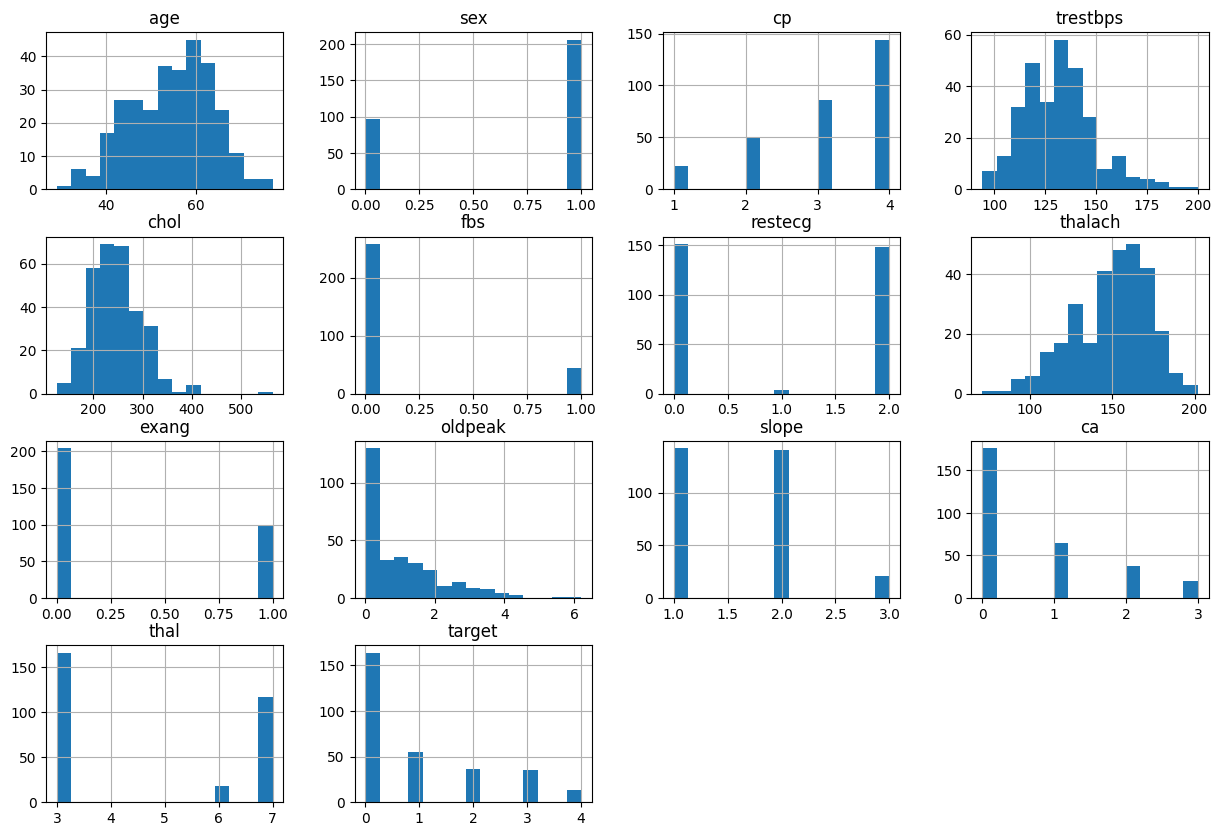

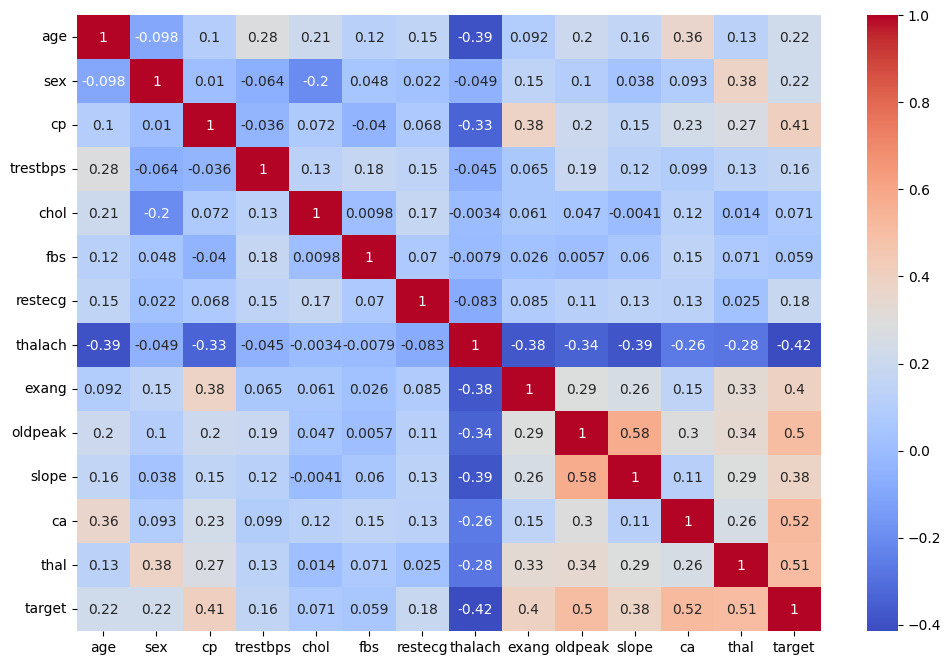

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic information and statistics
data.info()
data.describe()

# Visualize feature distributions
data.hist(bins=15, figsize=(15, 10))
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()



### Pre process the data

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Separate features and target
X = data.drop('target', axis=1)
y = data['target']

# Handle missing values by imputing them with the mean of each column
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Encode categorical variables
X['sex'] = X['sex'].map({0: 0, 1: 1})
X['cp'] = X['cp'].astype('category').cat.codes
X['restecg'] = X['restecg'].astype('category').cat.codes
X['slope'] = X['slope'].astype('category').cat.codes
X['thal'] = X['thal'].astype('category').cat.codes

# Additional check and handling for any remaining NaN values
X = X.fillna(X.mean())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check for NaN values
print("NaN values in X_train: ", np.isnan(X_train).sum())
print("NaN values in X_test: ", np.isnan(X_test).sum())



NaN values in X_train:  0
NaN values in X_test:  0


### Train a Simple Model

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))



Accuracy: 0.5409836065573771
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.33      0.25      0.29        12
           2       0.22      0.22      0.22         9
           3       0.18      0.29      0.22         7
           4       0.00      0.00      0.00         4

    accuracy                           0.54        61
   macro avg       0.31      0.33      0.32        61
weighted avg       0.51      0.54      0.52        61



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Plot Feature Importances (Baseline Model Interpretability)

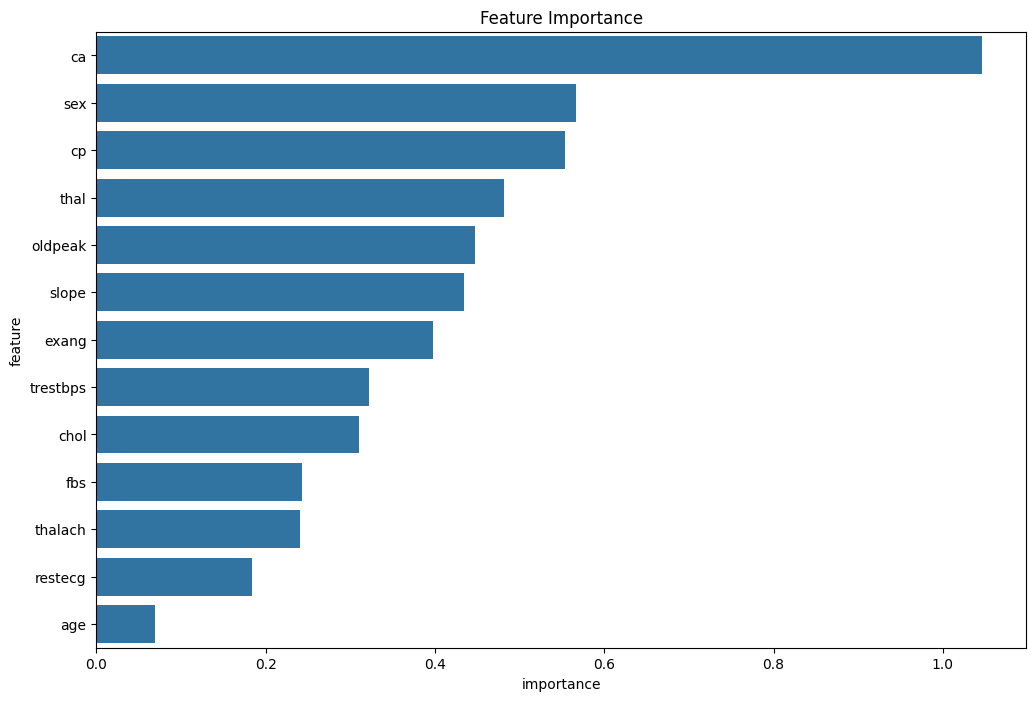

In [5]:
import numpy as np

try:
    feature_importance = abs(model.coef_[0])
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.show()
except AttributeError:
    print("The model does not have attribute 'coef_'")





### Apply LIME (Advanced Interpretability)

In [6]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['No Disease', 'Disease'], discretize_continuous=True)

# Explain an instance
i = 0  # Index of the test instance
exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)



### Apply SHAP (Advanced Interpretability)

SHAP values shape: (61, 13, 5)
X_test shape: (61, 13)


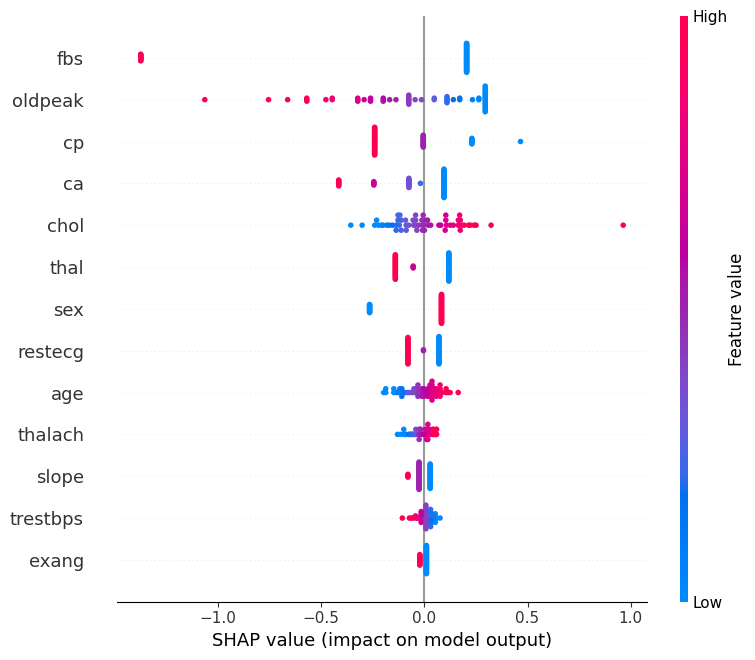

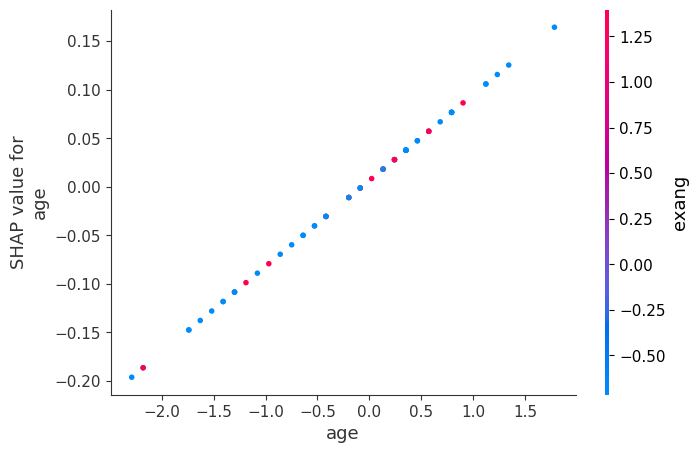

In [20]:
import shap

# Re-train the model to ensure consistency
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Create a SHAP explainer using the same training data
masker = shap.maskers.Independent(X_train)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer(X_test)

# Convert SHAP values to a numpy array if needed
shap_values_array = shap_values.values if isinstance(shap_values, shap.Explanation) else shap_values

# Print SHAP values to understand their structure
print("SHAP values shape:", shap_values_array.shape)
print("X_test shape:", X_test.shape)

# If the SHAP values have an additional dimension, select the correct one
if shap_values_array.ndim == 3:
    shap_values_array = shap_values_array[..., 1]  # Select SHAP values for the positive class

# SHAP summary plot
shap.summary_plot(shap_values_array, X_test, feature_names=X.columns)

# SHAP dependence plot for the 'age' feature
shap.dependence_plot('age', shap_values_array, X_test, feature_names=X.columns)

